In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTENC

data = pd.read_csv("healthcare-dataset-stroke-data.csv")

balanced_data = data.dropna()
balanced_data = balanced_data.drop(columns= "id")
balanced_data = balanced_data[balanced_data.age > 20]
balanced_data = balanced_data.drop(balanced_data.index[balanced_data["gender"] == "Other"])
balanced_data = balanced_data.drop(balanced_data.index[balanced_data["work_type"] == "Never_worked"])

features = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', "bmi", "smoking_status"]
cat_columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'hypertension', 'heart_disease']
num_columns = ['age', 'avg_glucose_level', 'bmi']

bal_data_train, bal_data_test = train_test_split(balanced_data, train_size = 0.8, random_state=1, stratify= balanced_data["stroke"])
bal_data_train, bal_data_val = train_test_split(bal_data_train, train_size = 0.8, random_state=1)

X_train = bal_data_train.drop('stroke', axis = 1)
y_train = bal_data_train['stroke']

X_val = bal_data_val.drop('stroke', axis = 1)
y_val = bal_data_val['stroke']

X_test = bal_data_test.drop('stroke', axis = 1)
y_test = bal_data_test['stroke']

In [2]:
smotenc = SMOTENC(cat_columns, random_state= 1)

X_train, y_train = smotenc.fit_resample(X_train, y_train)

In [3]:
preprocessing = ColumnTransformer([
    ('one-hot-encoder', OneHotEncoder(sparse_output=False), cat_columns),
    ('scaler', StandardScaler(), num_columns)
])

In [4]:
X_train2 = preprocessing.fit_transform(X_train)
X_val2 = preprocessing.transform(X_val)
X_test2 = preprocessing.transform(X_test)

Initial model starts at 0.07 recall

In [5]:
import tensorflow as tf

tf.random.set_seed(1)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=20))

model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(512, 'relu', kernel_regularizer= tf.keras.regularizers.l2(l=0.0001)))
model.add(tf.keras.layers.Dropout(0.8))

model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(256, 'relu', kernel_regularizer= tf.keras.regularizers.l2(l=0.0001)))
model.add(tf.keras.layers.Dropout(0.8))

model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(128, 'relu', kernel_regularizer= tf.keras.regularizers.l2(l=0.0001)))
model.add(tf.keras.layers.Dropout(0.8))


model.add(tf.keras.layers.Dense(1, "sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['Recall'])

In [6]:
model.summary()

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 20)               80        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 512)               10752     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

In [7]:
model_history = model.fit(X_train2, y_train, validation_data=(X_val2, y_val), epochs=100, callbacks= [callback])

Epoch 1/100
149/149 [==============================] - 3s 9ms/step - loss: 1.0410 - recall: 0.5215 - val_loss: 0.8265 - val_recall: 0.9737
Epoch 2/100
149/149 [==============================] - 1s 8ms/step - loss: 0.8368 - recall: 0.5839 - val_loss: 0.7207 - val_recall: 0.8947
Epoch 3/100
149/149 [==============================] - 1s 9ms/step - loss: 0.7420 - recall: 0.6231 - val_loss: 0.6613 - val_recall: 0.8947
Epoch 4/100
149/149 [==============================] - 1s 8ms/step - loss: 0.6602 - recall: 0.7129 - val_loss: 0.6234 - val_recall: 0.8421
Epoch 5/100
149/149 [==============================] - 1s 9ms/step - loss: 0.6328 - recall: 0.7395 - val_loss: 0.6374 - val_recall: 0.8421
Epoch 6/100
149/149 [==============================] - 1s 10ms/step - loss: 0.6180 - recall: 0.7858 - val_loss: 0.6171 - val_recall: 0.8684
Epoch 7/100
149/149 [==============================] - 1s 10ms/step - loss: 0.5956 - recall: 0.7947 - val_loss: 0.6182 - val_recall: 0.8421
Epoch 8/100
149/149 [====

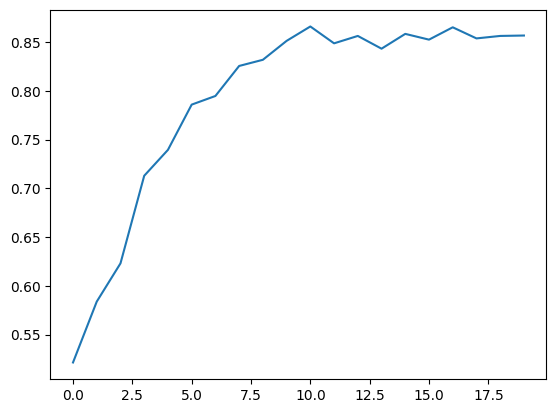

In [8]:
plt.plot(model_history.history['recall'])

In [9]:
model.evaluate(X_test2, y_test)

25/25 [==============================] - 0s 4ms/step - loss: 0.6617 - recall: 0.4524


[0.6617429256439209, 0.4523809552192688]

https://imbalanced-learn.org/stable/miscellaneous.html

https://www.freecodecamp.org/news/binary-classification-made-simple-with-tensorflow/


In [10]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [11]:
model.save('NN.h5')